## Competition Description


Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Thanks for all discussion forum and lot beautiful kernels. More information [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

! Steps obviously are process of iteration.

## 0 . Preparation

In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', 100)
# pd.set_option('display.max_rows', 200)
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

import scipy.stats as stats

from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

PATH = '...'

In [2]:
train = pd.read_csv('train.csv', sep=',').drop('Id', axis=1)
test = pd.read_csv('test.csv', sep=',').drop('Id', axis=1)

# train.info()
# test.info()

print("train   : {}\ntest    : {}".format(train.shape, test.shape))

train   : (1460, 80)
test    : (1459, 79)


* train contain one more column than test which is the target `SalePrice`

In [3]:
train.sample(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1139          30       RL         98.0     8731   Pave   NaN      IR1   
635          190       RH         60.0    10896   Pave  Pave      Reg   
809           75       RM         90.0     8100   Pave   NaN      Reg   
1433          60       RL         93.0    10261   Pave   NaN      IR1   
1210          60       RL         70.0    11218   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
1139         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
635          Bnk    AllPub    Inside  ...        0    NaN    NaN         NaN   
809          Lvl    AllPub    Corner  ...        0    NaN  MnPrv         NaN   
1433         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1210         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
1139       0      5    2007        WD         Normal     144000  
635        0      3    2007        WD        Abnorml     200000  
809        0     11    2009        WD         Normal     106000  
1433       0      5    2008        WD         Normal     186500  
1210     400      5    2010        WD         Normal     189000  

[5 rows x 80 columns]

## 1 . Exploratory Data Analysis

* All initial data are described by data_description.txt 
* `MSSubClass` defining the building class seems categorical, not **int64** which may implies linear relationship
* `YearBuilt`, `YearRemodAdd`, `MoSold`, `YrSold`, `GarageYrBlt` seems ordinal-categorical, to further explore

In [4]:
train['MSSubClass'] = train['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

* Train and test data have missing values in 19 and 32 features respectively
* These missing values might systematically missing and/or related to other features. But also some are simply null as None category refer to data_description.txt

* Missing values in `MasVnrType`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `BsmtQual`, `GarageYrBlt`, `GarageFinish`, `GarageQual`, `GarageCond`, `Alley`, `Fence`, `FireplaceQu`, `MiscFeature`, `PoolQC` means this feature not existed, thus impute **None**.

* Missing values in `MasVnrArea`, `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath`, `GarageArea`, `GarageCars` means this feature not existed, thus impute **0**, as it written in other data where the feature exists.

In [5]:
features1 = ['MasVnrType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'GarageType',
            'GarageFinish', 'GarageQual', 'GarageCond', 'Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC']
for feat in features1:
    train[feat] = train[feat].fillna('None')
    test[feat] = test[feat].fillna('None')

features2 = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 
            'GarageArea', 'GarageCars']  # 'GarageYrBlt'
for feat in features2:
    train[feat] = train[feat].fillna(0)
    test[feat] = test[feat].fillna(0)

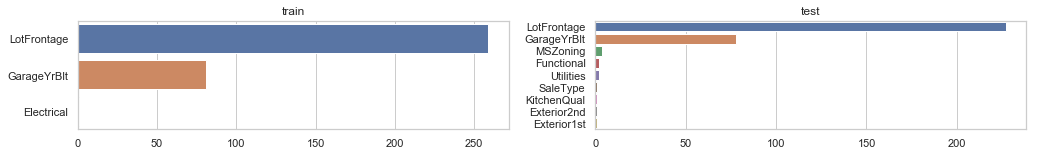

In [6]:
train_na = train.isnull().sum()
train_na = train_na[train_na>0].sort_values(ascending=False)

test_na = test.isnull().sum()
test_na = test_na[test_na>0].sort_values(ascending=False)

plt.figure(figsize=(17,2))
plt.subplot(1,2,1); sns.barplot(train_na, train_na.index).set_title('train')
plt.subplot(1,2,2); sns.barplot(test_na, test_na.index).set_title('test');

* To explore further, it might be usefull to fill, plotting before and after, then run through. Come back to this again is something found later.
*  Missing values in `Electrical`, `Exterior1st`, `Exterior2nd`, `Functional`, `KitchenQual`, `MSZoning`, `SaleType`, `Utilities` should be filled and simply no make sense to fill None or 0. Number of missing values in this features are insignificant. Try the most common value in the `Neighborhood` and/or `MSSubClass`.
* Missing values in `LotFrontage` is simply because it is not provided. But for every instance with this missing value have street, which it actually has value. Since the number of this missing value is significant, better to fill them. Since it countinous and there is indication of outliers, try median
* Missing values in `GarageYrBlt` relate to this feature is not exist. Since the number of this missing value is significant, better to fill them. Try 0

In [7]:
features3 = ['Electrical', 'Exterior1st', 'Exterior2nd', 'Functional', 'KitchenQual', 'MSZoning', 'SaleType', 'Utilities']
for feat in features3:
    mode_ = train[feat].mode()[0]
    train[feat] = train[feat].fillna(mode_)
    test[feat] = test[feat].fillna(mode_)
#     train[feat] = train.groupby(['Neighborhood', 'MSSubClass'])[feat].apply(lambda x: x.fillna(x.mode()[0]))
#     test[feat] = test.groupby(['Neighborhood', 'MSSubClass'])[feat].apply(lambda x: x.fillna(x.mode))

med_ = train['LotFrontage'].median()
train['LotFrontage'] = train['LotFrontage'].fillna(med_)
test['LotFrontage'] = test['LotFrontage'].fillna(med_)
    
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)
    
train.isnull().sum().sum()

0

- Target `SalePrice` is not normal distributed thus transformation need. The plot shows the distribution follow logarithmic pattern and  Unbounded Johnson seems most likely for this case. Parameters like skewness, kurtosis and normaltest would be useful to monitor the transformation.

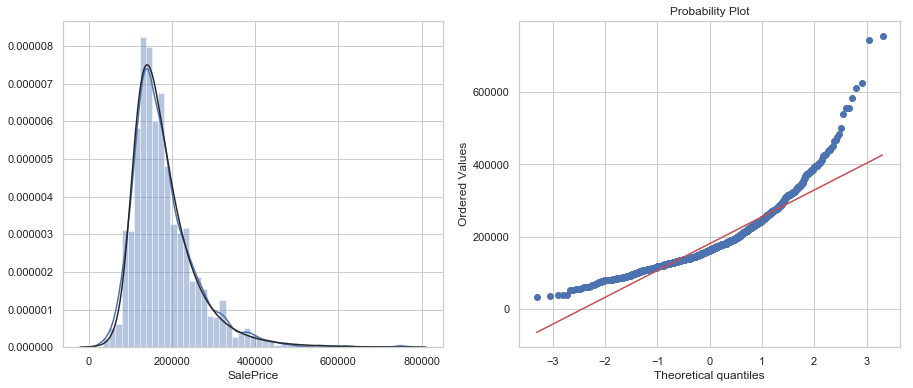

In [8]:
# plt.figure(1); plt.title('Johnson SU')
# sns.distplot(train.SalePrice, kde=False, fit=stats.johnsonsu)
# plt.figure(2); plt.title('Normal')
# sns.distplot(train.SalePrice, kde=False, fit=stats.norm)
# plt.figure(3); plt.title('Log Normal')
# sns.distplot(train.SalePrice, kde=False, fit=stats.lognorm)

plt.figure(figsize=(15,6))
plt.subplot(1,2,1); sns.distplot(train.SalePrice, kde=True, fit=stats.johnsonsu)
plt.subplot(1,2,2); stats.probplot(train.SalePrice, plot=plt);

* Some features are strongly correlated with target, like `OverallQual`, `GrLivArea`, `1stFlrSF`. Also, looks like multicollinearity occurs. 
* Some features are also strongly correlated with each other and dependent to each other, like between `GarageCars` and `GarageArea`.

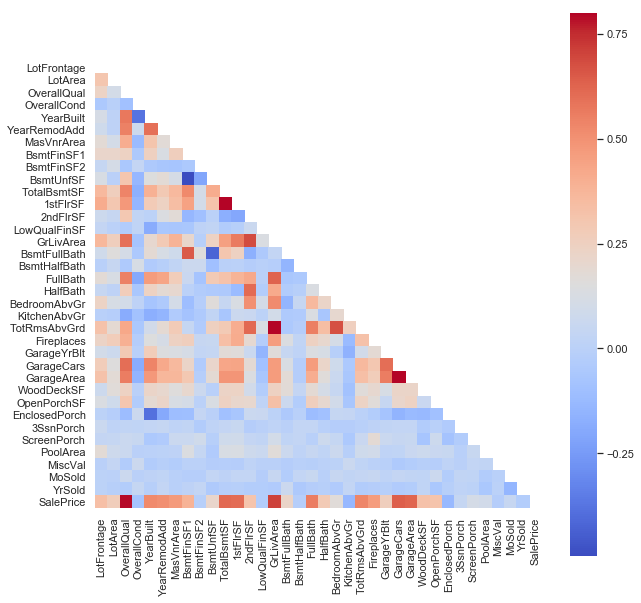

In [9]:
corr1 = train.corr(method='pearson')
# corr['SalePrice'].sort_values(ascending=False)

mask = np.zeros_like(corr1)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(corr1, mask=mask, vmax=0.8, annot=False, square=True, cmap='coolwarm', annot_kws={'size': 12})
#     ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True)

* To get more insight, try to encode categorical features based on each class `SalePrice` mean.
* Find more features that are strongly correlated with target and some correlated with each other. Thats guessable since some facility/condition is described by some features.

In [10]:
def encode(frame, feature):
    df = pd.DataFrame()
    df['val'] = frame[feature].unique()
    df.index = df.val
    df['spmean'] = frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    df = df.sort_values('spmean')
    df['ordering'] = range(1, df.shape[0]+1)
    for cat, o in df['ordering'].to_dict().items():
        frame.loc[frame[feature] == cat, feature+'_E'] = o

In [11]:
check = train.copy()
encoded_feat = []
for feat in train.select_dtypes(include='object').columns:  
    encode(check, feat)
    encoded_feat.append(feat+'_E')
print(encoded_feat)

['MSSubClass_E', 'MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


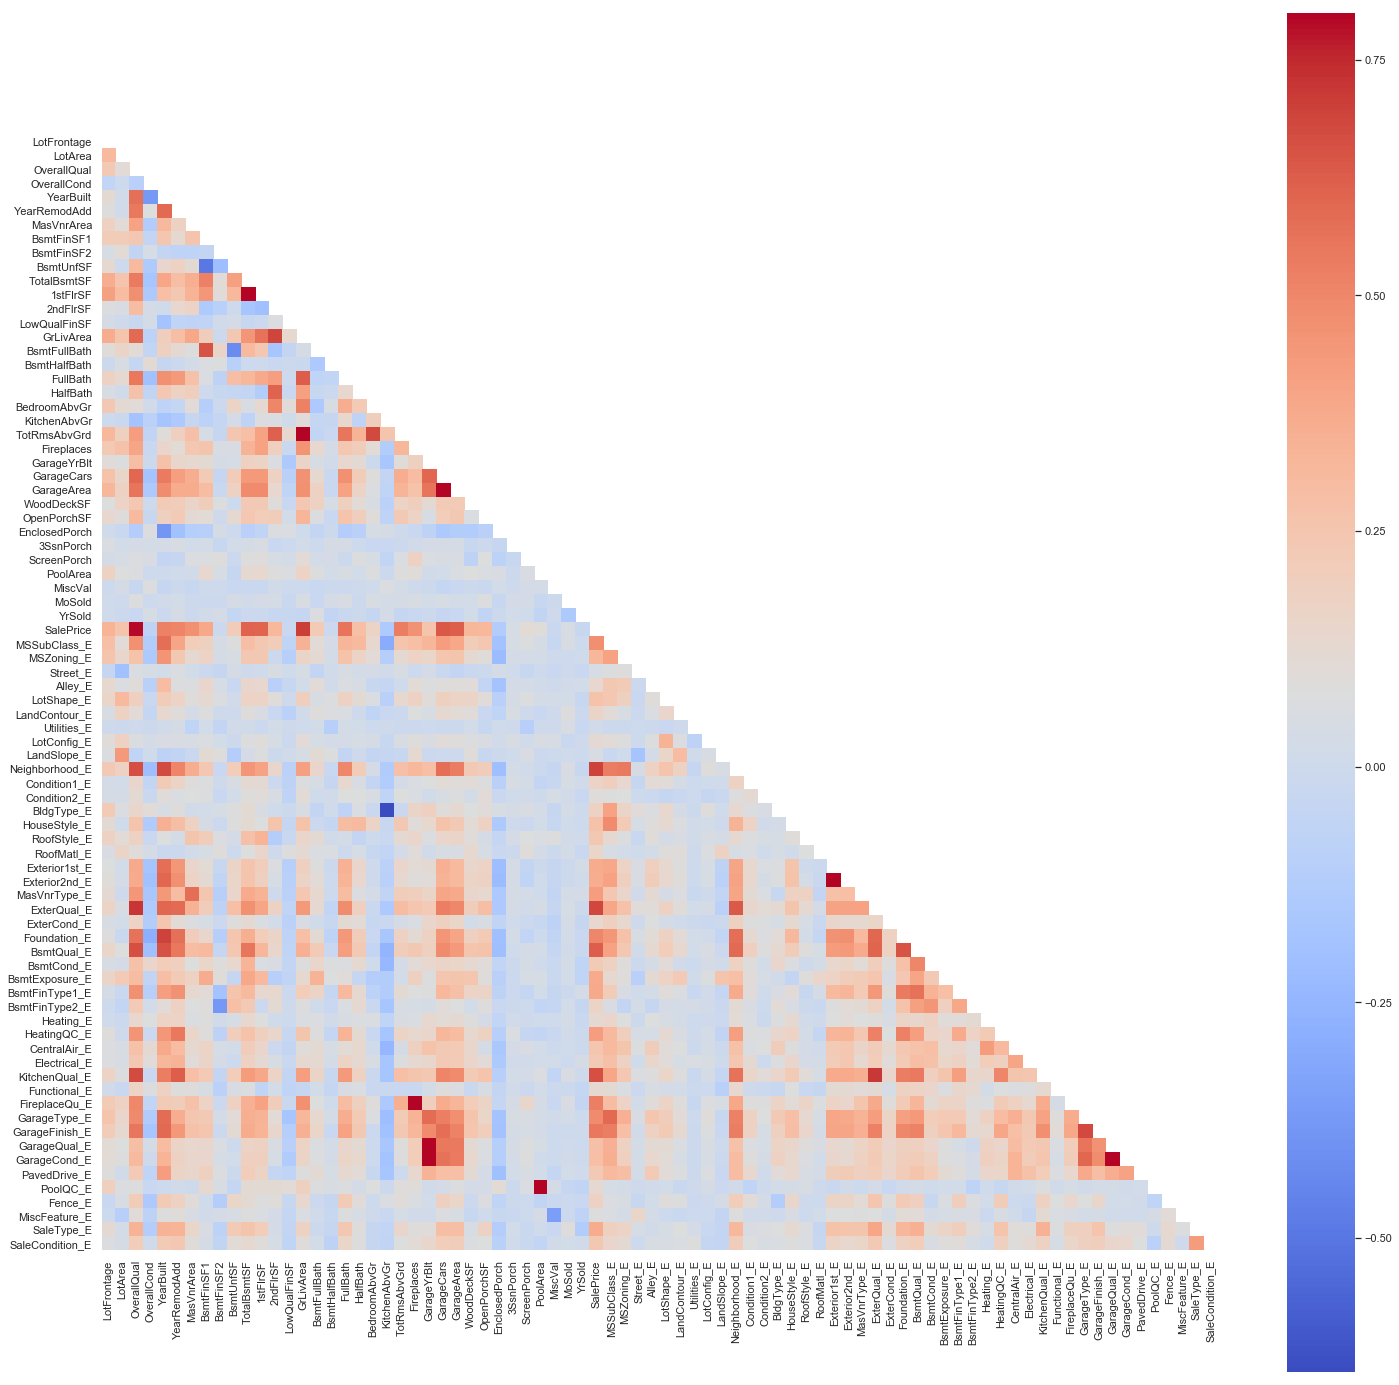

In [12]:
corr2 = check.corr(method='pearson')
# corr['SalePrice'].sort_values(ascending=False)

mask = np.zeros_like(corr2)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(25,25))
    ax = sns.heatmap(corr2, mask=mask, vmax=0.8, annot=False, square=True, cmap='coolwarm', annot_kws={'size': 5})

* Data points of `1stFlrSF`, `BsmtUnfSF`, `GarageArea`, `GrLivArea`, `LotArea`, `LotFrontage` and `TotalBsmtSF` features are not stacked at **0** as much as other numerical features. Those features exist in almost every single house. Fitting the regression line is easier for those features. In addition to that, outliers are very visible in those features.
* Data points of `2ndFlrSF`, `3SsnPorch`, `BsmtFinSF1`, `BsmtFinSF2`, `EnclosedPorch`, `LowQualFinSF`, `MasVnrArea`, `MiscVal`, `OpenPorchSF`, `PoolArea`, `ScreenPorch` and `WoodDeckSF` features are heavily stacked at **0**. Those features are rarer than the previous ones and they don't exist in every house, so they are sparse features. Those sparse features may not be reliable as the previous features when they are used as continuous features, because they are going to introduce bias to the regression function.
* `GarageYrBlt`, `YearBuilt` and `YearRemodAdd` are ordinal features, but a linear relationship can be seen from their plots. Houses with recent dates are more likely to be sold at higher prices.
* `1stFloorSF`, `2ndFloorSF`, `BsmtFinSF1`, `BsmtUnfSF`, `GarageArea`, `GarageYrBlt`, `GrLivArea`, `LotArea`, `LotFrontage`, `MasVnrArea`, `OpenPorchSF`, `TotalBsmtSF`, `WoodDeckSF`, `YearBuilt` and `YearRemodAdd` features have similar distributions in training set and test set. Models using these features, are less likely to overfit.
* `3SsnPorch`, `BsmtFinSF2`, `EnclosedPorch`, `LowQualFinSF`, `MiscVal`, `PoolArea` and `ScreenPorch` are too noisy. The distributions of those features in training set and test set doesn't match, so they might introduce bias to the models.

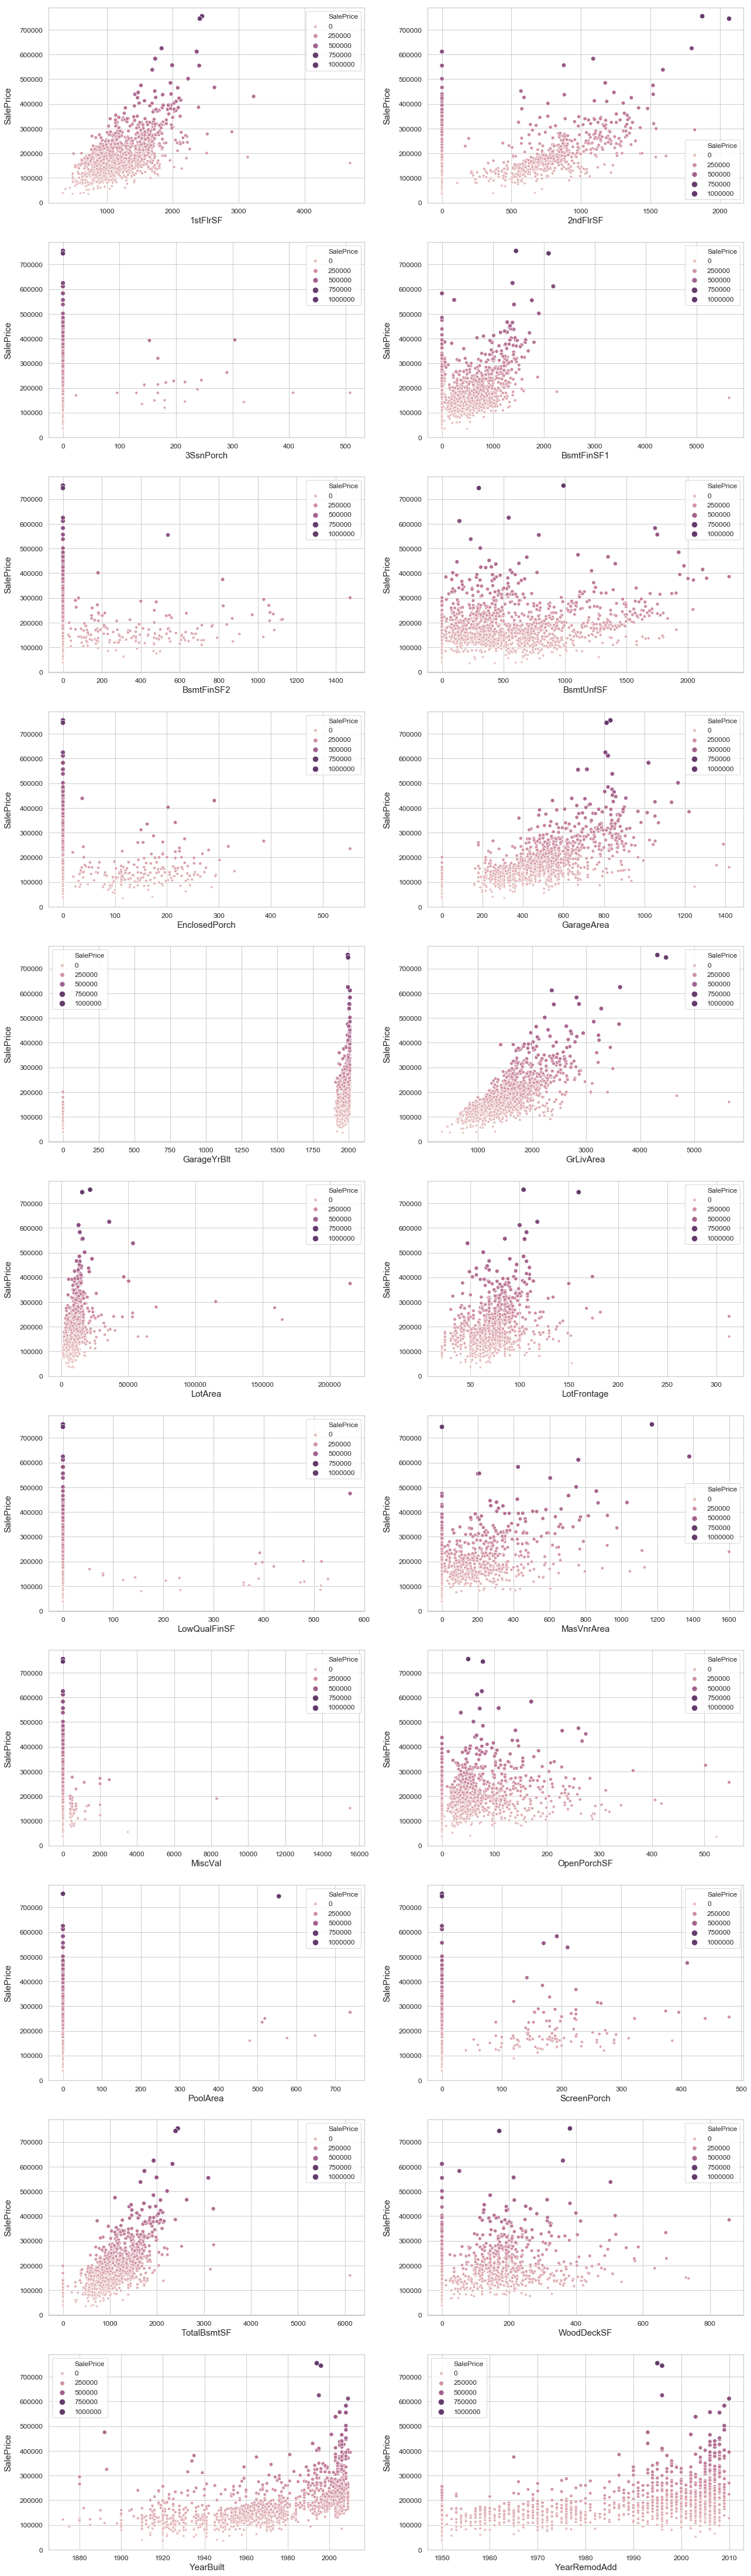

In [13]:
num_features = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2', 
                'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 
                'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 
                'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF', 
                'YearBuilt', 'YearRemodAdd']

fig, axs = plt.subplots(ncols=2, nrows=11, figsize=(12, 80))
plt.subplots_adjust(right=1.5)
cmap = sns.cubehelix_palette(dark=0.3, light=0.8, as_cmap=True)

for i, feature in enumerate(num_features, 1):    
    plt.subplot(11, 2, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', size='SalePrice', palette=cmap, data=train)
        
    plt.xlabel('{}'.format(feature), size=15)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 12})
        
plt.show()

* Categorical features may not strongly correlated with `SalePrice`. There are only **2** categorical features that have significant correlation with `SalePrice`, and they are `OverallQual` and `TotRmsAbvGrd`. A linear relationship can easily be seen from their plots. When the number of `OverallQual` and `TotRmsAbvGrd` increases, `SalePrice` tends to increase as well.
* Data points of `MoSold` and `YrSold` are uniformly distributed between classes. Those two features might have the least information about `SalePrice` among other categorical features.
* The other categorical features don't have significant correlation with `SalePrice`. However, values in some of those features have very distinct `SalePrice` maximums, minimums and interquartile ranges. Those features could be useful in tree based algorithms.  
* Values in some categorical features exist in one set, but doesn't exist in another set. This problem exists in `BedroomAbvGr`, `Condition2`, `Electrical`, `Exterior1st`, `Exterior2nd`, `Fireplaces`, `FullBath`, `GarageCars`, `GarageQual`, `Heating`, `KitchenAbvGr`, `MSSubClass`, `MiscFeature`, `PoolQC`, `RoofMatl` and `Utilities` features. This is a potential problem because some of the categorical features are going to be one-hot encoded, and because of that process, the feature counts of training set and test set might not match.
* Other categorical feature value counts in training set and test set are close to each other. Those features have similar distributions in both datasets, so they are more reliable than the previous ones.

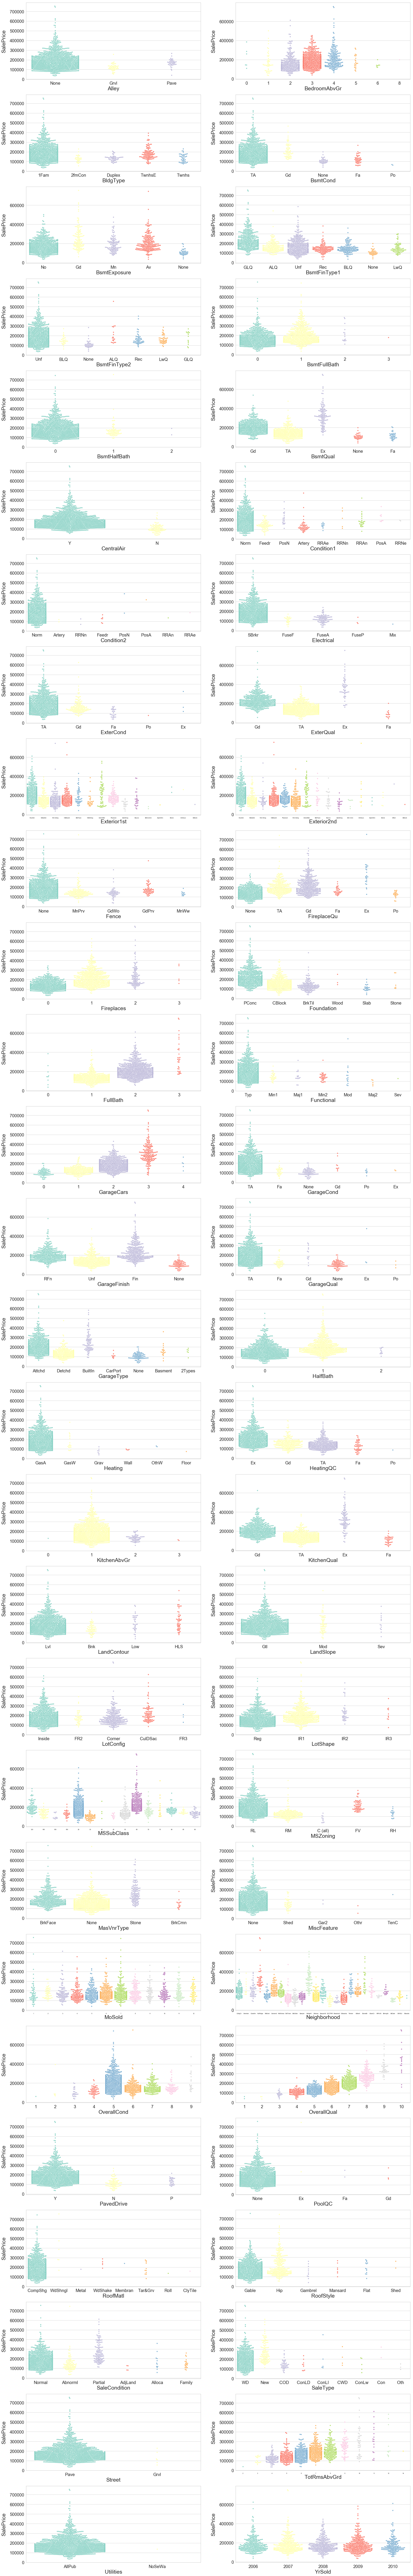

In [14]:
cat_features = ['Alley', 'BedroomAbvGr', 'BldgType', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 
                'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 
                'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 
                'Fireplaces', 'Foundation', 'FullBath', 'Functional', 'GarageCars', 
                'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'HalfBath', 
                'Heating', 'HeatingQC', 'KitchenAbvGr', 'KitchenQual', 'LandContour', 
                'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 
                'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood', 'OverallCond', 
                'OverallQual', 'PavedDrive', 'PoolQC', 'RoofMatl', 'RoofStyle', 
                'SaleCondition', 'SaleType', 'Street', 'TotRmsAbvGrd', 'Utilities', 'YrSold']

fig, axs = plt.subplots(ncols=2, nrows=28, figsize=(18, 120))
plt.subplots_adjust(right=1.5, top=1.5)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(28, 2, i)
    sns.swarmplot(x=feature, y='SalePrice', data=train, palette='Set3')
        
    plt.xlabel('{}'.format(feature), size=25)
    plt.ylabel('SalePrice', size=25, labelpad=15)
    
    for j in range(2):
        if train[feature].value_counts().shape[0] > 10:        
            plt.tick_params(axis='x', labelsize=7)
        else:
            plt.tick_params(axis='x', labelsize=20)
        plt.tick_params(axis='y', labelsize=20)
            
plt.show()

* Flag `GarageYrBlt`, `MoSold`, `YearBuilt`, `YearRemodAdd` and `YrSold` are date features. These numerical features that may not imply linear relationship. It might be better to use some of them as categorical features. 
* Many features are filled with **None** and **0** made them sparse data. Converting those features from multi class or continuous to binary might give better results.
* Target `SalePrice` distribution is highly skewed and long tailed and have potential outliers. Transformation and dealing with outliers may achieve better model.
* Many features are strongly correlated with each other. Also there is posible multicollinearity on the target. Create new feature depends on their interaction might overcome this issue.
* Continuous features that heavily stacked at **0** are also sparse features. Those features may add bias to the model without binning.
* Some categorical features are not informative for two reasons. The feature is either too homogenous like `Utilities` feature, or all of the values have the same characteristics like `MoSold` feature. Those features can be combined with other features or dropped completely.
* There are some numerical feature distributions that are too noisy. Their distributions in training and test set are quite different. They may require binning to overcome this problem. The same problem occurs for categorical features as well. There are some categorical feature values that doesn't exist in both training set and test set. They need to be grouped with other values.

In [15]:
train_1 = train.copy()
test_1 = test.copy()
train.sample(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
669          30       RL         80.0    11600   Pave  None      Reg   
985         190       RL         68.0    10880   Pave  None      Reg   
1202         50       RM         50.0     6000   Pave  None      Reg   
61           75       RM         60.0     7200   Pave  None      Reg   
304          75       RM         87.0    18386   Pave  None      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
669          Lvl    AllPub    Inside  ...        0   None  None        None   
985          Lvl    AllPub    Inside  ...        0   None  None        None   
1202         Lvl    AllPub    Corner  ...        0   None  None        None   
61           Lvl    AllPub    Inside  ...        0   None  None        None   
304          Lvl    AllPub    Inside  ...        0   None  None        None   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
669        0      7    2006        WD         Normal     137500  
985        0      8    2008     ConLD         Normal     125000  
1202       0      5    2009        WD         Normal     117000  
61         0      3    2007        WD         Normal     101000  
304        0      5    2008        WD         Normal     295000  

[5 rows x 80 columns]

## 2 . Feature Engineering & Transformation

In [209]:
train = train_1.copy()
test = test_1.copy()

- Transform target `SalePrice` to get normal distributed data. Unbounded Johnson at first seems most likely for this case resulting better value in skewness, kurtosis and normaltest. Log1p still possible to try.

In [210]:
y = train['SalePrice'].copy()
train.drop(['SalePrice'], axis=1, inplace=True)

yt_log1p = np.log1p(y)  # inverse np.expm1

def johnsonsu_transform(data):
    gamma, eta, epsilon, lmbda = stats.johnsonsu.fit(y)
    data_trans = gamma + eta*np.arcsinh((y-epsilon)/lmbda)
    return data_trans, gamma, eta, epsilon, lmbda

yt_johnsonsu, g, et, ep, l = johnsonsu_transform(y)

def johnsonsu_inverse(data, gamma=g, eta=et, epsilon=ep, lmbda=l):
    return lmbda*np.sinh((data-gamma)/eta) + epsilon

pd.DataFrame({'Skewness': [y.skew(), yt_log1p.skew(), yt_johnsonsu.skew()],
              'Kurtosis': [y.kurt(), yt_log1p.kurt(), yt_johnsonsu.kurt()],
              'p value': [stats.normaltest(y)[1], stats.normaltest(yt_log1p)[1], stats.normaltest(yt_johnsonsu)[1]]},
             index=['SalePrice', 'SalePrice transformed by log1p', 'SalePrice transformed by JohnsonSU'])

Skewness  Kurtosis        p value
SalePrice                           1.882876  6.536282  2.283848e-133
SalePrice transformed by log1p      0.121347  0.809519   2.891917e-06
SalePrice transformed by JohnsonSU -0.001482 -0.083982   8.218298e-01

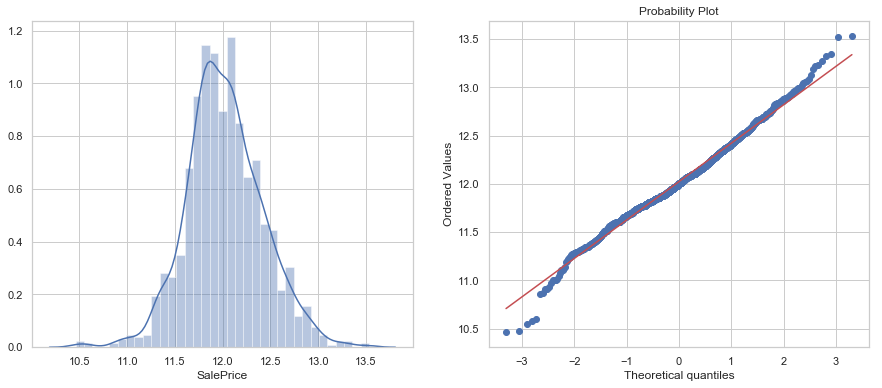

In [211]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1); sns.distplot(yt_log1p)
plt.subplot(1,2,2); stats.probplot(yt_log1p, plot=plt);

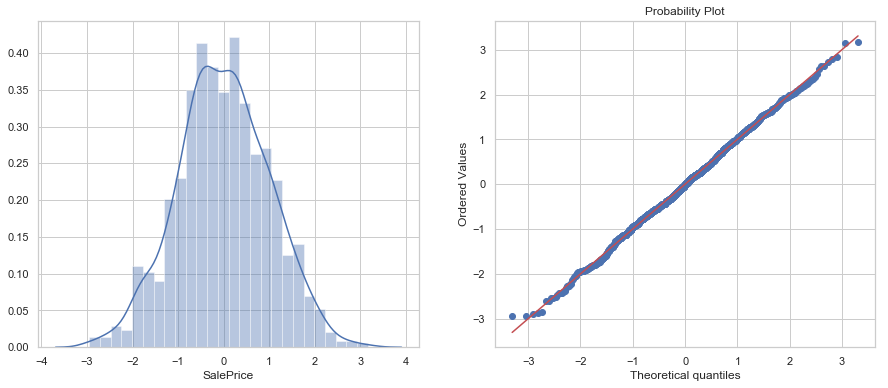

In [212]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1); sns.distplot(yt_johnsonsu)
plt.subplot(1,2,2); stats.probplot(yt_johnsonsu, plot=plt);

* As what has been found at EDA, creating features

In [213]:
def add_del_features(df):
    
    df['YrBuiltRemod'] = df['YearBuilt'] + df['YearRemodAdd']
    df['TotalSF1'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalSF2'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
    df['TotalPorchSF'] = df['OpenPorchSF'] + df['3SsnPorch'] + df['EnclosedPorch'] + df['ScreenPorch'] + df['WoodDeckSF']

    df['hasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndFlr'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['hasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

    # df['OverallRating'] = df['OverallQual'] + df['OverallCond']
    # df['NewHouse'] = 0
    # idx = df[df['YrSold'] == df['YearBuilt']].index
    # df.loc[idx, 'NewHouse'] = 1
    
    df.drop(['Utilities', 'Street', 'PoolQC'], axis=1, inplace=True)
    
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    
    return(df)

train = add_del_features(train)
test = add_del_features(test)

* Encode ordinal features

In [214]:
def encode_ordinal_features(df):
    BsmtCond_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4}
    BsmtExposure_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
    BsmtFinType_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
    BsmtQual_map = {'None': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    CentralAir_map = {'Y': 1, 'N': 0}
    ExterCond_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    ExterQual_map = {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    FireplaceQU_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    Functional_map = {'Typ': 0, 'Min1': 1, 'Min2': 1, 'Mod': 2, 'Maj1': 3, 'Maj2': 3, 'Sev': 4}
    GarageCond_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    GarageFinish_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
    GarageQual_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    HeatingQC_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
    KitchenQual_map = {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    LandSlope_map = {'Gtl': 1, 'Mod': 2, 'Sev': 3}
    LotShape_map = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}
    PavedDrive_map = {'N': 0, 'P': 1, 'Y': 2}

    df['BsmtCond'] = df['BsmtCond'].map(BsmtCond_map)
    df['BsmtExposure'] = df['BsmtExposure'].map(BsmtExposure_map)
    df['BsmtFinType1'] = df['BsmtFinType1'].map(BsmtFinType_map)
    df['BsmtFinType2'] = df['BsmtFinType2'].map(BsmtFinType_map)
    df['BsmtQual'] = df['BsmtQual'].map(BsmtQual_map)
    df['CentralAir'] = df['CentralAir'].map(CentralAir_map)
    df['ExterCond'] = df['ExterCond'].map(ExterCond_map)
    df['ExterQual'] = df['ExterQual'].map(ExterQual_map)
    df['FireplaceQu'] = df['FireplaceQu'].map(FireplaceQU_map)
    df['Functional'] = df['Functional'].map(Functional_map)
    df['GarageCond'] = df['GarageCond'].map(GarageCond_map)
    df['GarageFinish'] = df['GarageFinish'].map(GarageFinish_map)
    df['GarageQual'] = df['GarageQual'].map(GarageQual_map)
    df['HeatingQC'] = df['HeatingQC'].map(HeatingQC_map)
    df['KitchenQual'] = df['KitchenQual'].map(KitchenQual_map)
    df['LandSlope'] = df['LandSlope'].map(LandSlope_map)
    df['LotShape'] = df['LotShape'].map(LotShape_map)
    df['PavedDrive'] = df['PavedDrive'].map(PavedDrive_map)
    
    return(df)

train = encode_ordinal_features(train)
test = encode_ordinal_features(test)

In [215]:
train.shape, test.shape

((1460, 86), (1459, 86))

* Check outliers

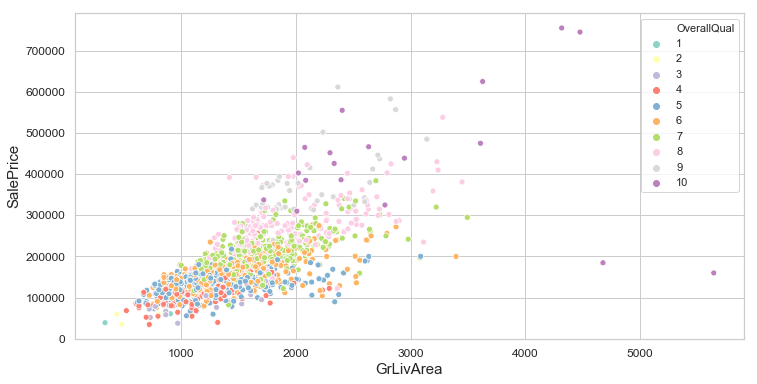

In [216]:
fig = plt.figure(figsize=(12, 6))
cmap = sns.color_palette('Set3', n_colors=10)
sns.scatterplot(x=train['GrLivArea'], y=y, hue=train['OverallQual'], palette=cmap)
plt.xlabel('GrLivArea', size=15)
plt.ylabel('SalePrice', size=15)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()

outliers_0 = [457, 523, 1298]   # 'OverallQual'<5 & 'SalePrice'>200000, 'GrLivArea'>4000 & 'SalePrice'<300000
outliers_1 = [691, 769, 1169, 1182]  # after model 1, later got unsignificant improvement (slight better mean error, but much worse std)

train = train.drop(outliers_0).reset_index(drop=True)
y = y.drop(outliers_0).reset_index(drop=True)
yt_log1p = yt_log1p.drop(outliers_0).reset_index(drop=True)  
yt_johnsonsu = yt_johnsonsu.drop(outliers_0).reset_index(drop=True)

In [217]:
from sklearn.preprocessing import OneHotEncoder

nominal_features = ['Alley', 'BldgType', 'Condition1', 'Condition2', 'Electrical', 
                    'Exterior1st', 'Exterior2nd', 'Fence', 'Foundation', 'GarageType', 
                    'Heating', 'HouseStyle', 'LandContour', 'LotConfig', 'MSSubClass',
                    'MSZoning', 'MasVnrType', 'MiscFeature', 'MoSold', 'Neighborhood',
                    'RoofMatl', 'RoofStyle', 'SaleCondition', 'SaleType', 'YrSold']

onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)
onehot.fit(train[nominal_features])

train = pd.concat([train, pd.DataFrame(onehot.transform(train[nominal_features]), columns=onehot.get_feature_names())], axis=1)
train.drop(nominal_features, axis=1, inplace=True)

test = pd.concat([test, pd.DataFrame(onehot.transform(test[nominal_features]), columns=onehot.get_feature_names())], axis=1)
test.drop(nominal_features, axis=1, inplace=True)

In [218]:
train.shape, test.shape

((1457, 262), (1459, 262))

In [219]:
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

cont_features = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
                 'BsmtUnfSF', 'EnclosedPorch', 'GarageArea', 'GrLivArea', 'LotArea', 
                 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 
                 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'WoodDeckSF']

skewness1 = train[cont_features].apply(lambda x: skew(x))
lamb = {feat:boxcox_normmax(train[feat]+10) for feat in skewness1[skewness1>0.5].index}
for feat in skewness1[skewness1>0.5].index:
    train[feat] = boxcox1p(train[feat], lamb[feat]) 
    test[feat] = boxcox1p(test[feat], lamb[feat])
skewness2 = train[cont_features].apply(lambda x: skew(x))

pd.concat([skewness1, skewness2], axis=1)

0          1
1stFlrSF        0.889179  -0.005792
2ndFlrSF        0.811079   0.888109
3SsnPorch      10.282886   7.629212
BsmtFinSF1      0.766260   0.350028
BsmtFinSF2      4.245879   2.517225
BsmtUnfSF       0.918905  -0.041313
EnclosedPorch   3.082631   2.183273
GarageArea      0.132116   0.132116
GrLivArea       1.010299   0.007377
LotArea        12.755946  -0.204226
LotFrontage     1.718434  -0.175102
LowQualFinSF    8.992490   7.293443
MasVnrArea      2.692486   0.793780
MiscVal        24.426546   5.069950
OpenPorchSF     2.342293   0.280960
PoolArea       15.927003  15.598339
ScreenPorch     4.113045   3.244982
TotalBsmtSF     0.512553   0.277219
WoodDeckSF      1.546764   0.685576

In [220]:
train.shape, y.shape, test.shape

((1457, 262), (1457,), (1459, 262))

In [221]:
sparse = []

for feature in train.columns:
    counts = train[feature].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train) * 100 > 99.94:
        sparse.append(feature)
        
train.drop(columns=sparse, inplace=True)
sparse

[]

In [222]:
train_2 = train.copy()
test_2 = test.copy()

## 3 . Model Creation

In [227]:
X_train = train
X_test = test
# y_train = yt_log1p
y_train = yt_johnsonsu

* Evaluation use Root Mean Squared Error `rmse` and Cross Validation Root Mean Squared Error `cv_rmse` (rmse of scores vector every fold).

In [228]:
FOLD = 10
SEED = 42

kf = KFold(n_splits=FOLD, shuffle=True, random_state=SEED)

def rmse(y_pred, y=y):
    return np.sqrt(mean_squared_error(y_pred, y))

def cv_rmse(model, X=X_train, y=y_train):
    return np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf))

In [205]:
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=np.arange(14.5, 15.6, 0.1),
                              cv=kf))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(alphas=np.arange(0.0001, 0.0009, 0.0001),
                              random_state=SEED,
                              cv=kf))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(alphas=np.arange(0.0001, 0.0008, 0.0001),
                                        l1_ratio=np.arange(0.8, 1, 0.025),
                                        cv=kf))

svr = make_pipeline(RobustScaler(),
                    SVR(C=20,
                        epsilon=0.008, 
                        gamma=0.0003))

gbr = GradientBoostingRegressor(n_estimators=3000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=SEED)

lgbmr = LGBMRegressor(objective='regression', 
                      num_leaves=4,
                      learning_rate=0.01, 
                      n_estimators=5000,
                      max_bin=200, 
                      bagging_fraction=0.75,
                      bagging_freq=5, 
                      bagging_seed=SEED,
                      feature_fraction=0.2,
                      feature_fraction_seed=SEED,
                      verbose=0)

xgbr = XGBRegressor(learning_rate=0.01,
                    n_estimators=3500,
                    max_depth=3,
                    gamma=0.001,
                    subsample=0.7,
                    colsample_bytree=0.7,
                    objective='reg:linear',
                    nthread=-1,
                    seed=SEED,
                    reg_alpha=0.0001)

stack = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, svr, gbr, lgbmr, xgbr),
                            meta_regressor=xgbr,
                            use_features_in_secondary=True)

models = {'RidgeCV': ridge,
          'LassoCV': lasso, 
          'ElasticNetCV': elasticnet,
          'SupportVectorRegressor': svr, 
          'LightGBMRegressor': lgbmr
#           'GradientBoostingRegressor': gbr,  
#           'XGBoostRegressor': xgbr, 
#           'StackingCVRegressor': stack
         }

## log1p

In [182]:
predictions = {}
scores = {}

for name, model in models.items():
    start = datetime.now()
    print('[{}] Running {}'.format(start, name))
    
    model.fit(X_train, y_train)
    predictions[name] = np.expm1(model.predict(X_train))
#     predictions[name] = johnsonsu_inverse(model.predict(X_train))
    
    score = cv_rmse(model, X_train, y_train)
    scores[name] = (score.mean(), score.std())
    
    end = datetime.now()
    
    print('[{}] Finished Running {} in {:.2f}s'.format(end, name, (end - start).total_seconds()))
    print('[{}] {} CV RMSE (transf price) Mean: {:.6f} / Std: {:.6f}'.format(datetime.now(), name, scores[name][0], scores[name][1]))
    print('[{}] {} RMSE (actual price): {:.6f}\n'.format(datetime.now(), name, rmse(predictions[name])))

[2019-11-08 21:14:03.744235] Running RidgeCV
[2019-11-08 21:14:33.967526] Finished Running RidgeCV in 30.22s
[2019-11-08 21:14:33.968521] RidgeCV CV RMSE (transf price) Mean: 0.108605 / Std: 0.013349
[2019-11-08 21:14:33.968521] RidgeCV RMSE (actual price): 17502.953339

[2019-11-08 21:14:33.970520] Running LassoCV
[2019-11-08 21:14:56.632115] Finished Running LassoCV in 22.66s
[2019-11-08 21:14:56.633114] LassoCV CV RMSE (transf price) Mean: 0.107798 / Std: 0.012857
[2019-11-08 21:14:56.634114] LassoCV RMSE (actual price): 18049.123831

[2019-11-08 21:14:56.634114] Running ElasticNetCV
[2019-11-08 21:17:36.726147] Finished Running ElasticNetCV in 160.09s
[2019-11-08 21:17:36.727146] ElasticNetCV CV RMSE (transf price) Mean: 0.107734 / Std: 0.012828
[2019-11-08 21:17:36.727146] ElasticNetCV RMSE (actual price): 18031.146548

[2019-11-08 21:17:36.727146] Running SupportVectorRegressor
[2019-11-08 21:17:47.484492] Finished Running SupportVectorRegressor in 10.76s
[2019-11-08 21:17:47.485

## johnsonSU

In [229]:
predictions = {}
scores = {}

for name, model in models.items():
    start = datetime.now()
    print('[{}] Running {}'.format(start, name))
    
    model.fit(X_train, y_train)
#     predictions[name] = np.expm1(model.predict(X_train))
    predictions[name] = johnsonsu_inverse(model.predict(X_train))
    
    score = cv_rmse(model, X_train, y_train)
    scores[name] = (score.mean(), score.std())
    
    end = datetime.now()
    
    print('[{}] Finished Running {} in {:.2f}s'.format(end, name, (end - start).total_seconds()))
    print('[{}] {} CV RMSE (transf price) Mean: {:.6f} / Std: {:.6f}'.format(datetime.now(), name, scores[name][0], scores[name][1]))
    print('[{}] {} RMSE (actual price): {:.6f}\n'.format(datetime.now(), name, rmse(predictions[name])))

[2019-11-08 21:36:03.252287] Running RidgeCV
[2019-11-08 21:36:29.347395] Finished Running RidgeCV in 26.10s
[2019-11-08 21:36:29.347395] RidgeCV CV RMSE (transf price) Mean: 0.260972 / Std: 0.034105
[2019-11-08 21:36:29.347395] RidgeCV RMSE (actual price): 17570.204002

[2019-11-08 21:36:29.348393] Running LassoCV
[2019-11-08 21:36:53.413386] Finished Running LassoCV in 24.06s
[2019-11-08 21:36:53.414385] LassoCV CV RMSE (transf price) Mean: 0.258803 / Std: 0.034611
[2019-11-08 21:36:53.414385] LassoCV RMSE (actual price): 17524.091560

[2019-11-08 21:36:53.415383] Running ElasticNetCV
[2019-11-08 21:40:02.321560] Finished Running ElasticNetCV in 188.91s
[2019-11-08 21:40:02.321560] ElasticNetCV CV RMSE (transf price) Mean: 0.259243 / Std: 0.034727
[2019-11-08 21:40:02.321560] ElasticNetCV RMSE (actual price): 17422.946883

[2019-11-08 21:40:02.323558] Running SupportVectorRegressor
[2019-11-08 21:40:13.151332] Finished Running SupportVectorRegressor in 10.83s
[2019-11-08 21:40:13.153

## 4 . Evaluation

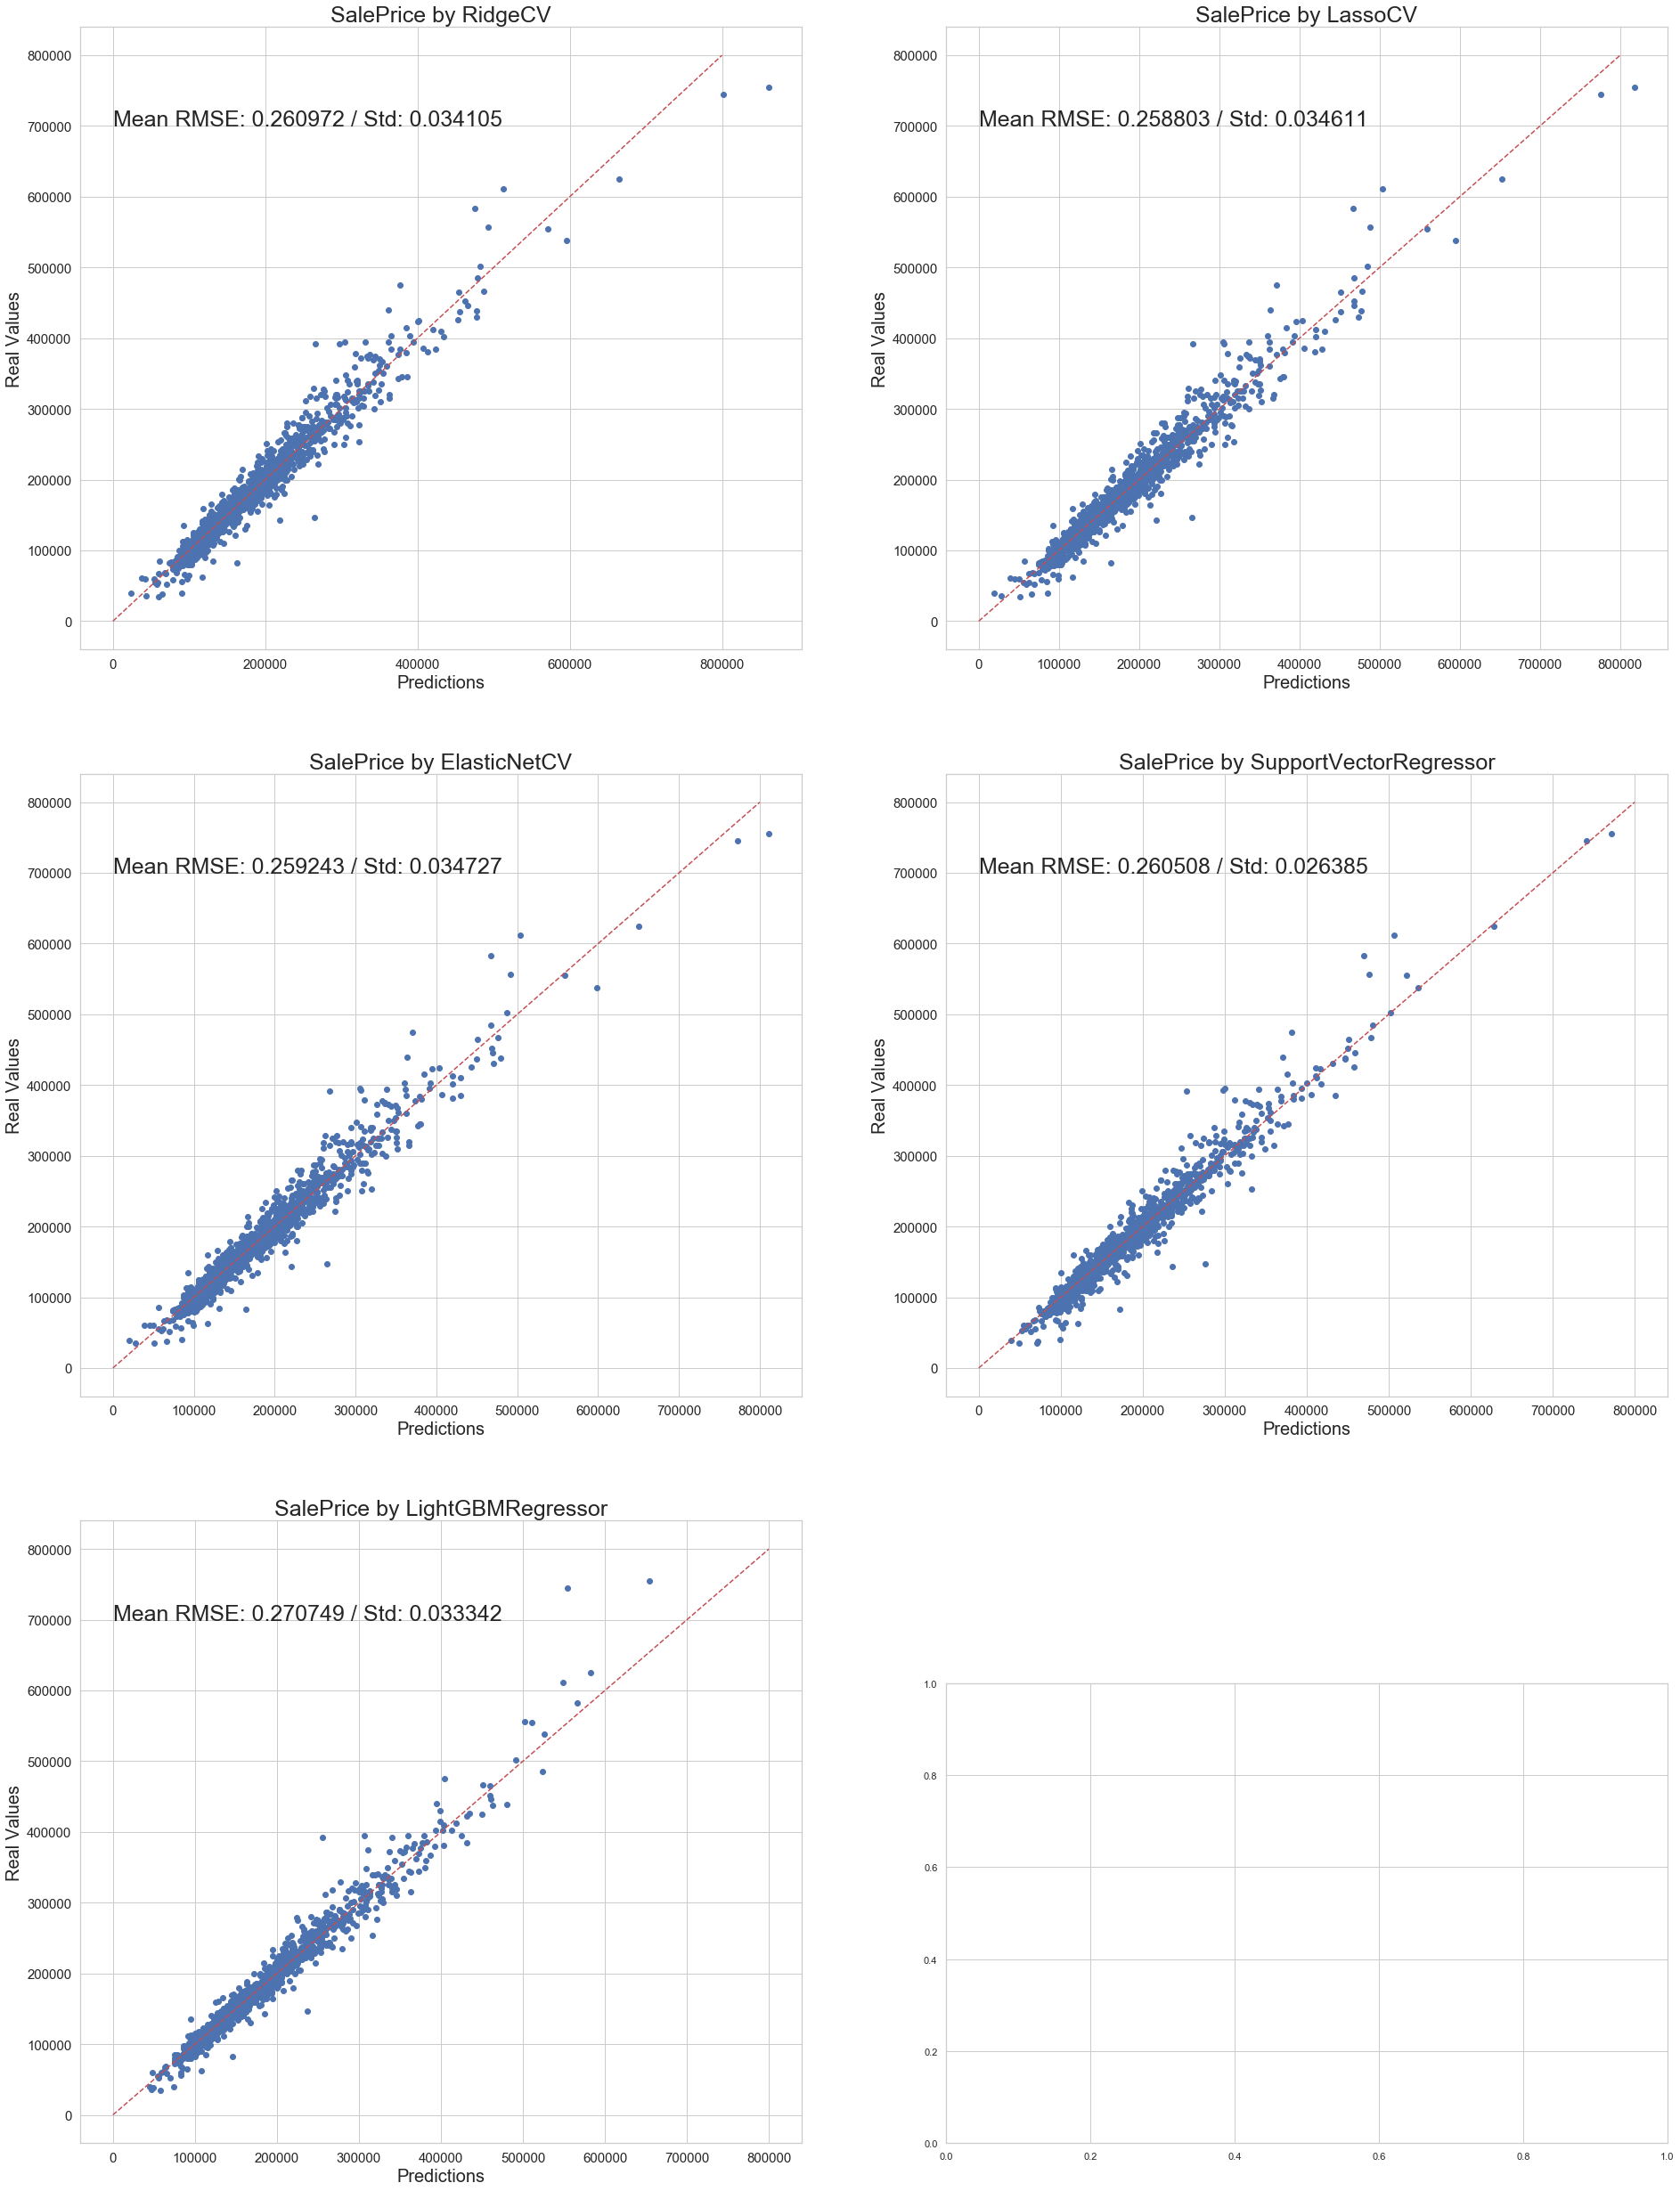

In [231]:
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(18, 24))
plt.subplots_adjust(top=1.5, right=1.5)

for i, model in enumerate(models, 1):
    plt.subplot(3, 2, i)
    plt.scatter(predictions[model], y)
    plt.plot([0, 800000], [0, 800000], '--r')

    plt.xlabel('Predictions', size=20)
    plt.ylabel('Real Values', size=20)
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)

    plt.title('SalePrice by {}'.format(model), size=25)
    plt.text(0, 700000, 'Mean RMSE: {:.6f} / Std: {:.6f}'.format(scores[model][0], scores[model][1]), fontsize=25)

plt.show()

In [251]:
results = pd.concat([y, pd.DataFrame(predictions)], axis=1)
results.describe()

SalePrice        RidgeCV        LassoCV   ElasticNetCV  \
count    1457.000000    1457.000000    1457.000000    1457.000000   
mean   180881.397392  180054.030089  179982.532302  179998.250255   
std     79497.995015   77919.143559   77296.115814   77287.751622   
min     34900.000000   24159.448926   18768.268357   19934.499995   
25%    129900.000000  128899.492583  129276.411040  129358.068091   
50%    163000.000000  161292.109207  161976.450433  161460.152880   
75%    214000.000000  211646.735526  211819.495946  211963.062603   
max    755000.000000  861563.224864  818162.487360  811123.403413   

       SupportVectorRegressor  LightGBMRegressor  
count             1457.000000        1457.000000  
mean            180363.344980      180037.460514  
std              75637.403471       76335.518310  
min              38895.285668       45157.276626  
25%             130547.084804      129878.227066  
50%             162758.998033      162796.200537  
75%             211668.922646      210509.114358  
max             771987.639490      654443.081731

* Drop outlier to get better model std

In [233]:
def checkOutlier(df, m = 4):
    uniOutlier = dict().fromkeys(df.columns, None)
    outSample = abs(df - df.mean()) > m * df.std()
    outSum = (abs(df - df.mean()) > m * df.std()).sum()
    for key in uniOutlier.keys():
        uniOutlier[key] = set(outSample.index[outSample.loc[:, key]])
    outportion = outSum / df.shape[0]
    #print("No outlier Vars: " ,outSum.index[outportion == 0].tolist())
    #print("Outlier Portion")
    #print(outportion[outportion != 0].index.tolist())
    #print(outportion[outportion != 0].values.tolist())
    outportion = outportion[outportion != 0].sort_values()
    outlierLst = outportion.index.tolist()
    return uniOutlier, outlierLst

def outlierCounter(outlierDict, exceptionLst = ['SalePrice']):
    inter = Counter()
    name = defaultdict(list)
    coreKey = set(outlierDict.keys()).difference(exceptionLst)
    for key in coreKey:
        value = outlierDict[key]
        for val in value:
            inter[val] += 1
            name[val].append(key)
    res = pd.DataFrame([inter, name], index = ['count', 'variable']).T
    res = res.sort_values('count', ascending = False)
    return res

In [234]:
outlierCounter(checkOutlier(results.drop(['SalePrice'], axis=1), m=4)[0])

count                                           variable
440      5  [LassoCV, SupportVectorRegressor, ElasticNetCV...
689      5  [LassoCV, SupportVectorRegressor, ElasticNetCV...
767      5  [LassoCV, SupportVectorRegressor, ElasticNetCV...
896      5  [LassoCV, SupportVectorRegressor, ElasticNetCV...
1167     5  [LassoCV, SupportVectorRegressor, ElasticNetCV...
1180     5  [LassoCV, SupportVectorRegressor, ElasticNetCV...
1044     3         [ElasticNetCV, RidgeCV, LightGBMRegressor]
178      2        [SupportVectorRegressor, LightGBMRegressor]
796      1                                [LightGBMRegressor]
801      1                                [LightGBMRegressor]

In [187]:
temp = outlierCounter(checkOutlier(results.drop(['SalePrice'], axis=1), m=4)[0])
temp[temp['count'] >= 3].index

Int64Index([440, 689, 767, 896, 1167, 1180], dtype='int64')

In [188]:
outliers_1 = [691, 769, 1169, 1182]   # m=5
outliers_2 = [440, 894, 1042] # m=4

## 5 . Blend

In [253]:
X = results[['RidgeCV', 'LassoCV', 'ElasticNetCV', 'SupportVectorRegressor', 'LightGBMRegressor']]
y = results['SalePrice']

In [264]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X,y)
lin.coef_, lin.score(X , y)

(array([ 0.6624086 , -1.90578761,  1.28857896,  0.17315314,  0.80412095]),
 0.9683804027861155)

In [265]:
rmse(lin.predict(X))

14131.402093135132

## 6 . Submission

In [305]:
pd.DataFrame({'RidgeCV': johnsonsu_inverse(models['RidgeCV'].predict(X_test)),
              'LassoCV': johnsonsu_inverse(models['LassoCV'].predict(X_test)),
              'ElasticNetCV': johnsonsu_inverse(models['ElasticNetCV'].predict(X_test)),
              'SupportVectorRegressor': johnsonsu_inverse(models['SupportVectorRegressor'].predict(X_test)),
              'LightGBMRegressor': johnsonsu_inverse(models['LightGBMRegressor'].predict(X_test))
             }).head()

RidgeCV        LassoCV   ElasticNetCV  SupportVectorRegressor  \
0  120791.774654  121713.911377  121609.888580           121431.516990   
1  157707.654219  157355.009817  157684.517121           162464.981045   
2  182917.316717  183275.327682  183324.536908           188272.201735   
3  203147.844004  203640.640665  203465.062930           203156.949805   
4  187935.259234  189606.373929  190081.162993           189627.310651   

   LightGBMRegressor  
0      123230.491230  
1      163118.462558  
2      184252.444062  
3      195619.003993  
4      188352.708855

In [306]:
submission = pd.read_csv('test.csv')
submission['SalePrice'] = lin.predict(pd.DataFrame({'RidgeCV': johnsonsu_inverse(models['RidgeCV'].predict(X_test)),
                                                    'LassoCV': johnsonsu_inverse(models['LassoCV'].predict(X_test)),
                                                    'ElasticNetCV': johnsonsu_inverse(models['ElasticNetCV'].predict(X_test)),
                                                    'SupportVectorRegressor': johnsonsu_inverse(models['SupportVectorRegressor'].predict(X_test)),
                                                    'LightGBMRegressor': johnsonsu_inverse(models['LightGBMRegressor'].predict(X_test))
                                                   }))

In [307]:
submission = submission[['Id', 'SalePrice']]
submission.to_csv('submissions.csv', header=True, index=False)
submission.head(10)  # lb 0.11855

Id      SalePrice
0  1461  121551.266254
1  1462  163745.132241
2  1463  185547.677372
3  1464  197806.679337
4  1465  189044.172542
5  1466  171773.240780
6  1467  171794.860281
7  1468  164498.783944
8  1469  173569.447473
9  1470  126028.175900

In [309]:
submission.shape

(1459, 2)